# Import all libraries

In [1]:
#Import Libraries
import numpy as np 
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.svm import SVC
import time
import pickle
import os
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input, Dense, Dropout

# Preprocessing and Feature extraction

In [123]:
def preprocess_spectrogram(df):#if the entire column is NaNs, we drop it, otherwise we replace the NaNs with the mean of the column
    #first we drop the columns with only NaNs
    df = df.dropna(axis=1, how='all')
    # Convert to numeric array
    matrix = df.to_numpy(dtype=float)            
    freqs = df.columns.to_numpy(dtype=float) 
    
    # Replace any NaNs with mean of the column without the Nans
    if np.isnan(matrix).any():
      col_means = np.nanmean(matrix, axis=0)
      inds = np.where(np.isnan(matrix))
      matrix[np.where(np.isnan(matrix))] = np.take(np.nanmean(matrix, axis=0), inds[1])
    return matrix, freqs


def extract_envelopes(matrix, freqs, sigma_u= 0.00025, sigma_l= 0.00025):#based on paper we classify the hand gestures based on the envelopes of their micro doppler signature
    #Shape is (time, frequency)
    # Create a Boolean mask for positive frequencies
    N, K=matrix.shape #shape variables according to paper
    pos_mask = freqs >= 0#returns series of booleans
    neg_mask= freqs <0
    # Select columns where frequency is positive
    pos_half = matrix[:, pos_mask]
    neg_half = matrix[:, neg_mask] 
    f_neg=freqs[neg_mask] 
    f_pos=freqs[pos_mask] 
    
    # Eu and El
    EU = np.sum(pos_half**2, axis=1)   #sum from 0 to K/2 -1 of Spectogram squared for each time frame so axis 1
    EL = np.sum(neg_half**2, axis=1)   #sum from K/2 to K-1 of Spectogram squared
    TU = sigma_u * EU # we then scale the energy to define thresholds
    TL = sigma_l * EL
    #We use these thresholds to see which frequencies have a significant energy
    eU = []
    eL = []
    #freq where amplitude greater 
    for i in range(matrix.shape[0]):
        
        col_pos=pos_half[i,:]#we go through it for each time step
        col_neg=neg_half[i,:]

        #freq where amplitude greater than threshold
        above_thresh_pos=np.where(col_pos>=TU[i])[0]
        above_thresh_neg=np.where(np.abs(col_neg)>=TL[i])[0]

        if len(above_thresh_pos)>0:
            valid_freqs_pos=f_pos[above_thresh_pos]
            if valid_freqs_pos.size > 0:
                eU.append( np.max(valid_freqs_pos))# max values have the most influence
        if len(above_thresh_neg)>0:
            valid_freqs_neg=f_neg[above_thresh_neg]
            if valid_freqs_neg.size > 0:
                eL.append( np.min(valid_freqs_neg))
      
    return eU, eL

    
def build_feature_vector(eU, eL):
    return np.concatenate([eU, eL])

# Optimal sigma parameter for best feature extraction

In [55]:

people = ['Person A', 'Person B', 'Person C', 'Person D', 'Person E', 'Person F']  
gestures = ['click', 'pinch', 'swipe', 'wave']


#test for different sigma parameters
sigma_list = [ 0.000525, 0.0005, 0.000475, 0.00045, 0.000425, 0.0004, 0.000375, 0.00035, 0.000325, 0.0003, 0.000275, 0.00025, 0.000225, 0.00020, 0.000175, 0.00015]
X_names=[0,1,2,3,4,5,6,7,8,9,10,11,12,13, 14, 15]
for name in X_names:
    globals()[f'X_sigma{name}'] = {}
    globals()[f'y_sigma{name}'] =[]
    

for sigma, name in zip(sigma_list, X_names):
    for person in people:
        for gesture in gestures:
            gesture_path = os.path.join(person, person, gesture)
            if os.path.exists(gesture_path):
                files = [f for f in os.listdir(gesture_path) if f.endswith('.csv')]
                dfs = []
                for f in files:
                    df = pd.read_csv(os.path.join(gesture_path, f), dtype=np.float32)
                    matrix, freqs = preprocess_spectrogram(df)
                    pos_env, neg_env = extract_envelopes(matrix, freqs, sigma, sigma)
                    features = build_feature_vector(pos_env, neg_env)
                    dfs.append(features)
                    globals()[f'y_sigma{name}'].append(gesture)
                globals()[f'X_sigma{name}'][f'{person}_{gesture}'] = dfs

    print('done')

    

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


# padding and scaling of different datasets to test for highest accuracy

In [87]:
scaler=StandardScaler()
encoder= LabelEncoder()
Shuffle_state = 4720
#padding and scaling
for name in X_names:
    globals()[f'flat_X_sigma{name}'] = [vec for sublist in globals()[f'X_sigma{name}'].values() for vec in sublist]
    max_len = max(len(f) for f in globals()[f'flat_X_sigma{name}'])
    globals()[f'y_encoded{name}']=encoder.fit_transform(globals()[f'y_sigma{name}'])
    globals()[f'padded_X_sigma{name}'] = np.array([np.pad(f, (0, max_len - len(f)), 'constant') for f in globals()[f'flat_X_sigma{name}']])
    globals()[f'scaled_X_sigma{name}'] = scaler.fit_transform(globals()[f'padded_X_sigma{name}'])
    globals()[f'X_train_sigma{name}'], globals()[f'X_test_sigma{name}'],globals()[f'y_train_sigma{name}'], globals()[f'y_test_sigma{name}'] = train_test_split(globals()[f'scaled_X_sigma{name}'], globals()[f'y_encoded{name}'], test_size=0.2, stratify=globals()[f'y_encoded{name}'], random_state=Shuffle_state)


In [91]:
#knn feature testing 
n_neighbors=[1, 3 , 5, 7, 9, 11, 13, 15]# not too high to avoid overfitting, recommend sqrt of n which is 960/4
metrics=['euclidean', 'manhattan', 'chebyshev', 'minkowski']

accuracy=[]
best_accuracies=[]
for name in X_names:
    accuracy_list=[]
    for neighbor in n_neighbors:
        for metric in metrics:
                globals()[f'X_knn_sigma{name}'] = KNeighborsClassifier(n_neighbors=neighbor, metric=metric)#Knn model according to article
                globals()[f'X_knn_sigma{name}'].fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
                globals()[f'y_pred_sigma{name}'] = (globals()[f'X_knn_sigma{name}']).predict(globals()[f'X_test_sigma{name}'])
                acc = accuracy_score(globals()[f'y_test_sigma{name}'], globals()[f'y_pred_sigma{name}'])
                accuracy_list.append((acc, neighbor, metric))
    accuracy.append(accuracy_list)
    best= max(accuracy_list, key=lambda x: x[0])
    best_accuracies.append(best[0])
    print(f" Sigma {name}: Best Accuracy = {best[0]:.4f} with k={best[1]}, metric='{best[2]}'")
            

 Sigma 0: Best Accuracy = 0.5990 with k=9, metric='manhattan'
 Sigma 1: Best Accuracy = 0.6458 with k=7, metric='manhattan'
 Sigma 2: Best Accuracy = 0.6146 with k=13, metric='manhattan'
 Sigma 3: Best Accuracy = 0.6562 with k=15, metric='manhattan'
 Sigma 4: Best Accuracy = 0.5938 with k=13, metric='manhattan'
 Sigma 5: Best Accuracy = 0.5781 with k=5, metric='manhattan'
 Sigma 6: Best Accuracy = 0.5833 with k=9, metric='manhattan'
 Sigma 7: Best Accuracy = 0.5625 with k=9, metric='manhattan'
 Sigma 8: Best Accuracy = 0.6302 with k=13, metric='manhattan'
 Sigma 9: Best Accuracy = 0.6458 with k=9, metric='manhattan'
 Sigma 10: Best Accuracy = 0.6667 with k=9, metric='manhattan'
 Sigma 11: Best Accuracy = 0.6667 with k=5, metric='manhattan'
 Sigma 12: Best Accuracy = 0.6250 with k=13, metric='euclidean'
 Sigma 13: Best Accuracy = 0.6406 with k=7, metric='euclidean'
 Sigma 14: Best Accuracy = 0.6719 with k=7, metric='euclidean'
 Sigma 15: Best Accuracy = 0.6094 with k=1, metric='euclidea

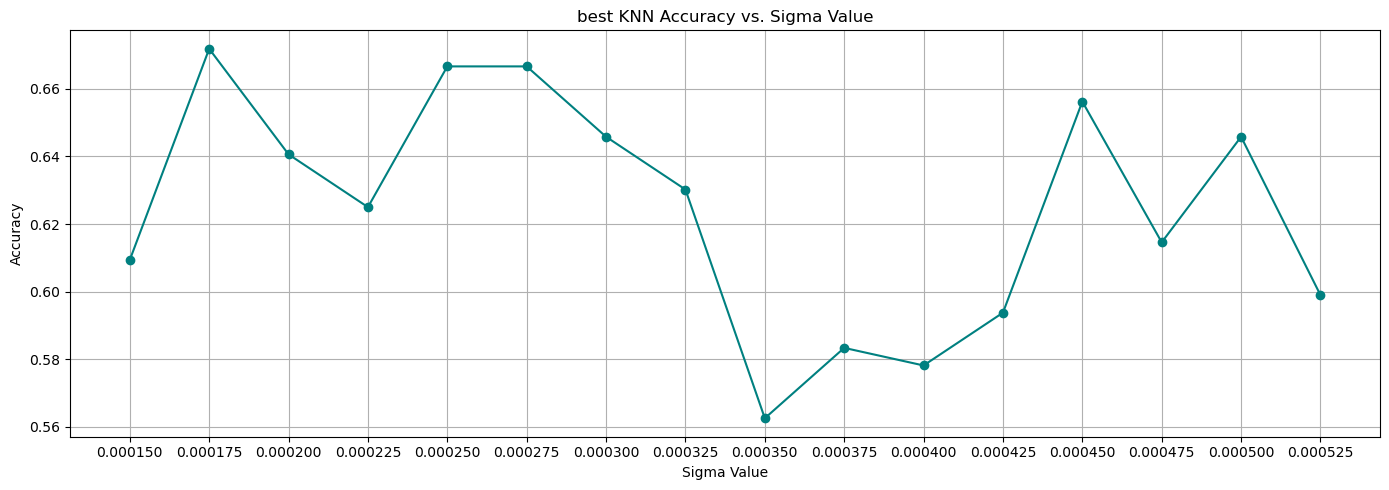

In [92]:

plt.figure(figsize=(14, 5))
plt.plot(sigma_list, best_accuracies, marker='o', linestyle='-', color='teal')
plt.title("best KNN Accuracy vs. Sigma Value")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()

since the highest accuracy is obtained with the knn parameters: k=31, metric='manhattan', below is a plot of the evolution of the KNN accuracy depending on the sigma value. As can be seen, the accuracy is far more influences by the sigma value than the parameters, as the same parameters are almost always responsible for the same accuracies.

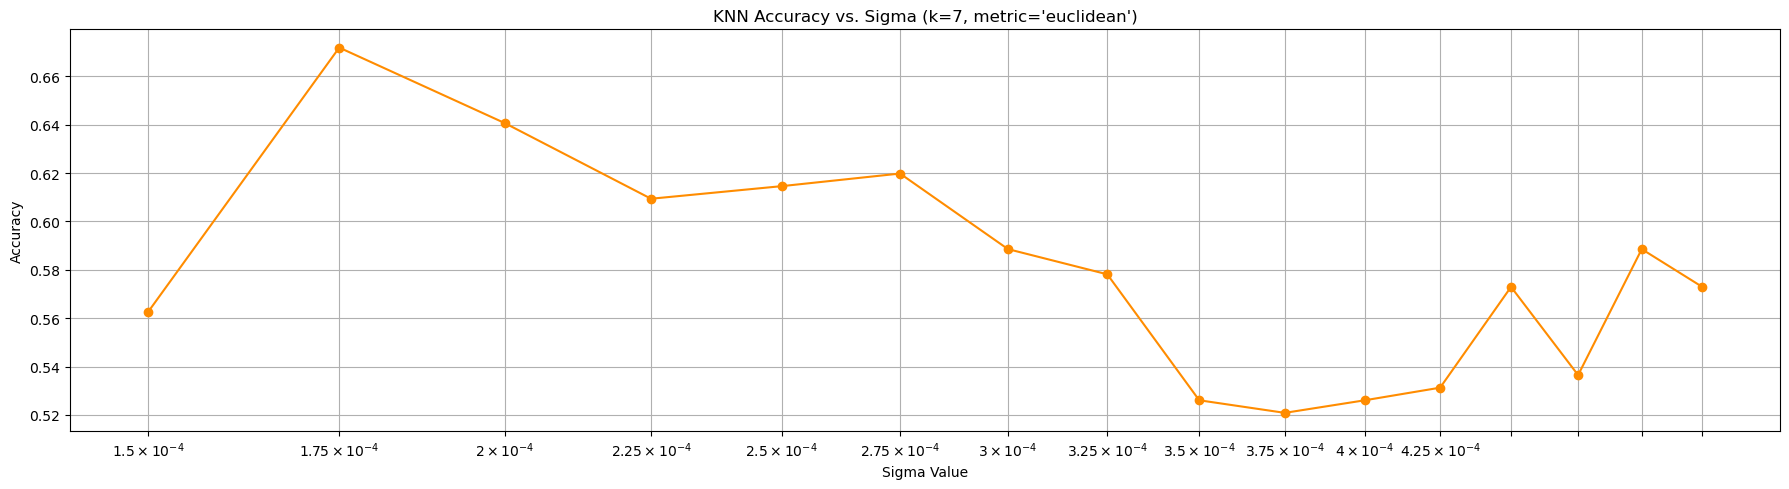

In [99]:
# Fixed KNN parameters
k = 7
metric = 'euclidean'


# Store accuracy for each sigma
acc_vs_sigma = []

for name in X_names:
    model = KNeighborsClassifier(n_neighbors=k, metric=metric)
    model.fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
    globals()[f'y_pred_sigma{name}'] = model.predict(globals()[f'X_test_sigma{name}'])
    acc = accuracy_score(globals()[f'y_test_sigma{name}'],  globals()[f'y_pred_sigma{name}'])
    acc_vs_sigma.append(acc)

# Plot
plt.figure(figsize=(18, 5))
plt.plot(sigma_list, acc_vs_sigma, marker='o', linestyle='-', color='darkorange')
plt.title(f"KNN Accuracy vs. Sigma (k={k}, metric='{metric}')")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xscale('log')  # Optional: log scale for better spacing
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()

## Effect of the different KNN parameters for the sigma value for which the highest accuracy is obtained

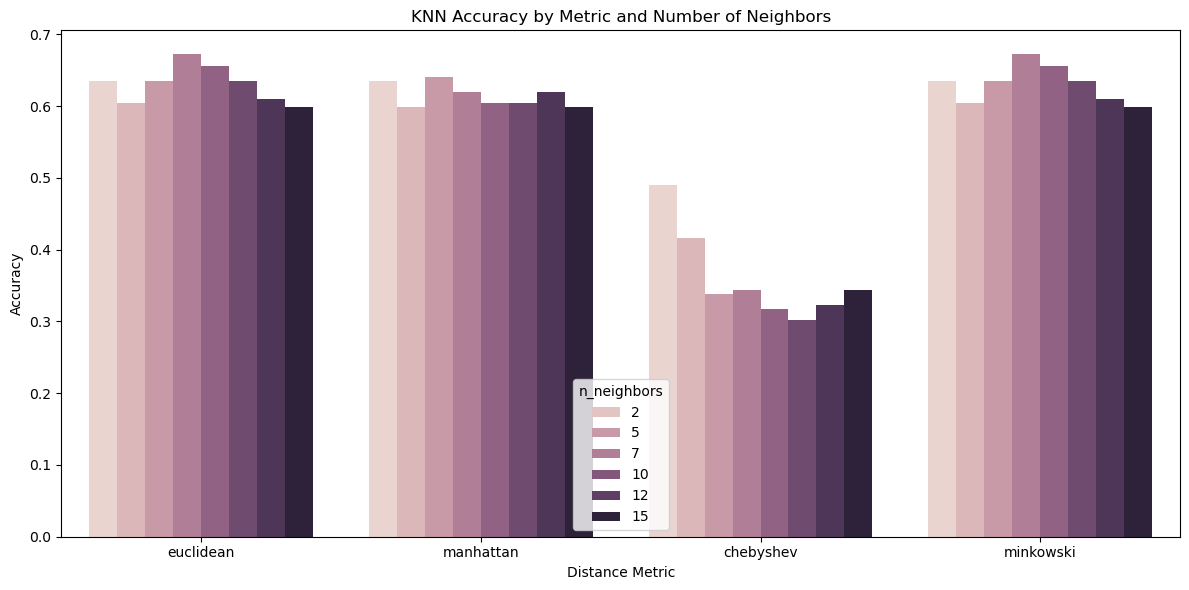

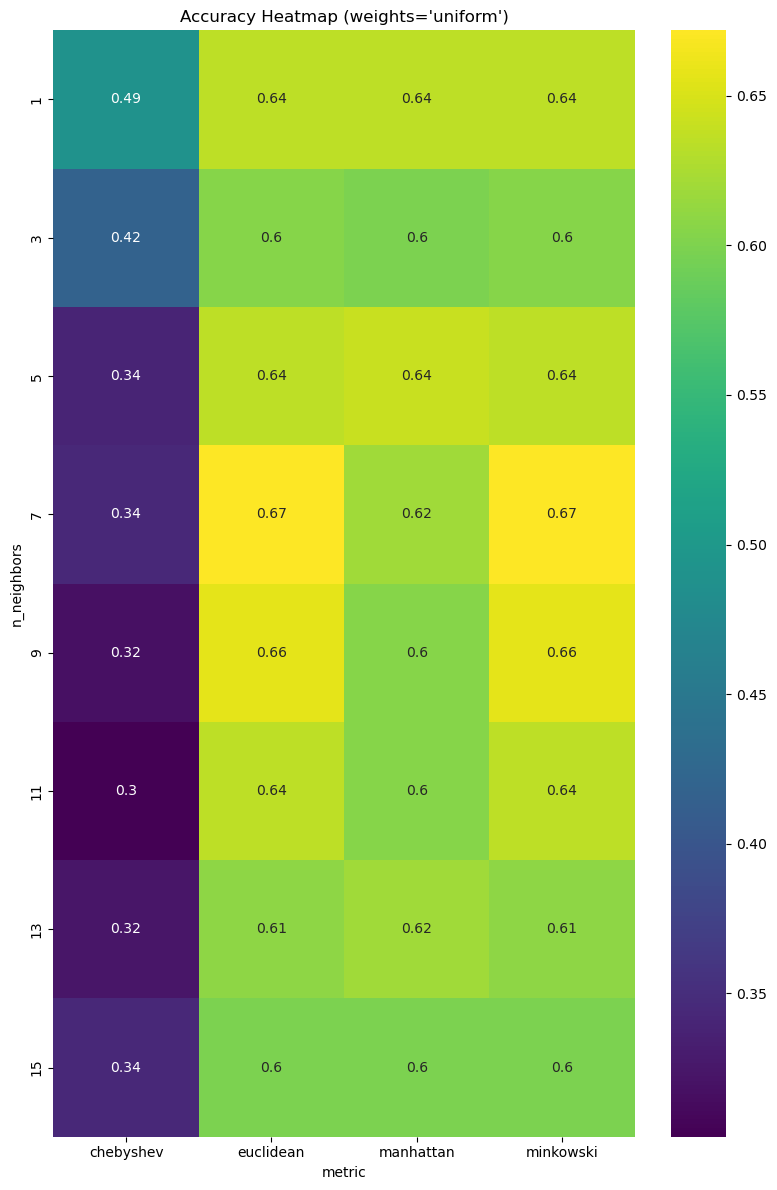

In [102]:

results=[]
for neighbor in n_neighbors:
        for metric in metrics:
            X_knn_sigma14= KNeighborsClassifier(n_neighbors=neighbor, metric=metric)
            X_knn_sigma14.fit(X_train_sigma14, y_train_sigma14)
            y_pred_sigma14 = X_knn_sigma14.predict(X_test_sigma14)
            acc = accuracy_score(y_test_sigma14, y_pred_sigma14)
            results.append((neighbor, metric, acc))

df = pd.DataFrame(results, columns=['n_neighbors', 'metric', 'accuracy'])

plt.figure(figsize=(12, 6))
sn.barplot(data=df, x='metric', y='accuracy', hue='n_neighbors', errorbar=None)
plt.title("KNN Accuracy by Metric and Number of Neighbors")
plt.ylabel("Accuracy")
plt.xlabel("Distance Metric")
plt.legend(title="n_neighbors")
plt.tight_layout()
plt.show()

#Heatmap for fixed weights
pivot = df.pivot(index='n_neighbors', columns='metric', values='accuracy')


plt.figure(figsize=(8, 12))
sn.heatmap(pivot, annot=True, cmap='viridis')
plt.title("Accuracy Heatmap (weights='uniform')")
plt.ylabel("n_neighbors")
plt.xlabel("metric")
plt.tight_layout()
plt.show()

This confirms the parameters given in the paper as giving the highest accuracy, which is 70% and given with the metric 'manhattan' and k=3, this is given for a sigma value of 0.000225

    n_neighbors     metric  accuracy
12            7  euclidean  0.671875
13            7  manhattan  0.619792
14            7  chebyshev  0.343750
15            7  minkowski  0.671875


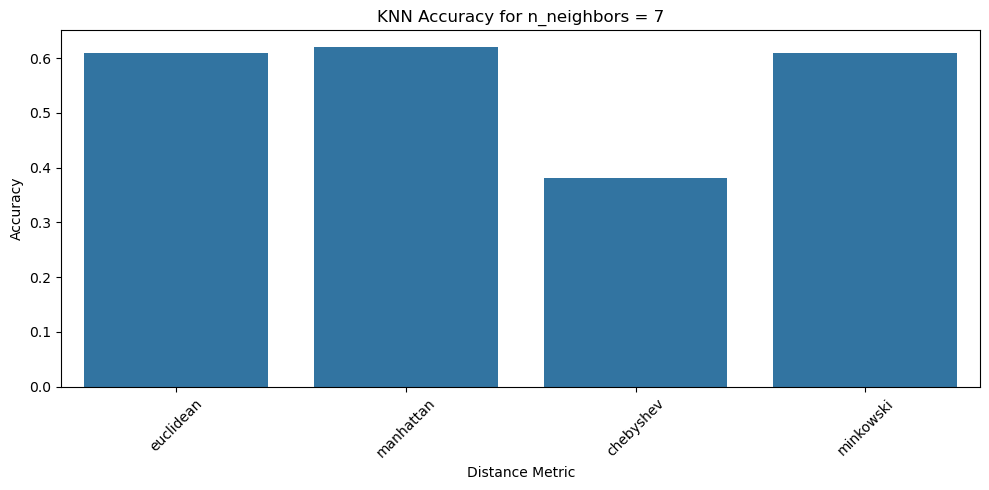

In [103]:
# Filter for n_neighbors = 3
df_7 = df[df['n_neighbors'] == 7]
print(df_7)
# Barplot for k=7
plt.figure(figsize=(10, 5))
sn.barplot(data=df_3, x='metric', y='accuracy', errorbar=None)
plt.title("KNN Accuracy for n_neighbors = 7")
plt.ylabel("Accuracy")
plt.xlabel("Distance Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Model accuracy per gesture

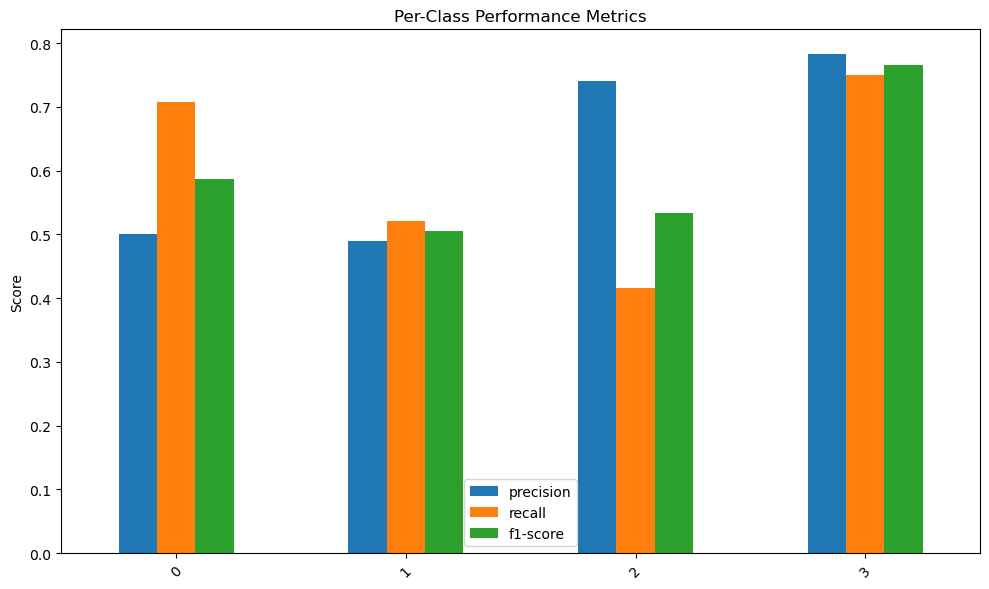

In [104]:
#model accuracy per gesture
report = classification_report(y_test_sigma14, y_pred_sigma14, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:-3][['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title("Per-Class Performance Metrics")
plt.ylabel("Score")

plt.xticks(rotation=45)
plt.tight_layout()

    n_neighbors     metric  accuracy
12            7  euclidean  0.671875
13            7  manhattan  0.619792
14            7  chebyshev  0.343750
15            7  minkowski  0.671875


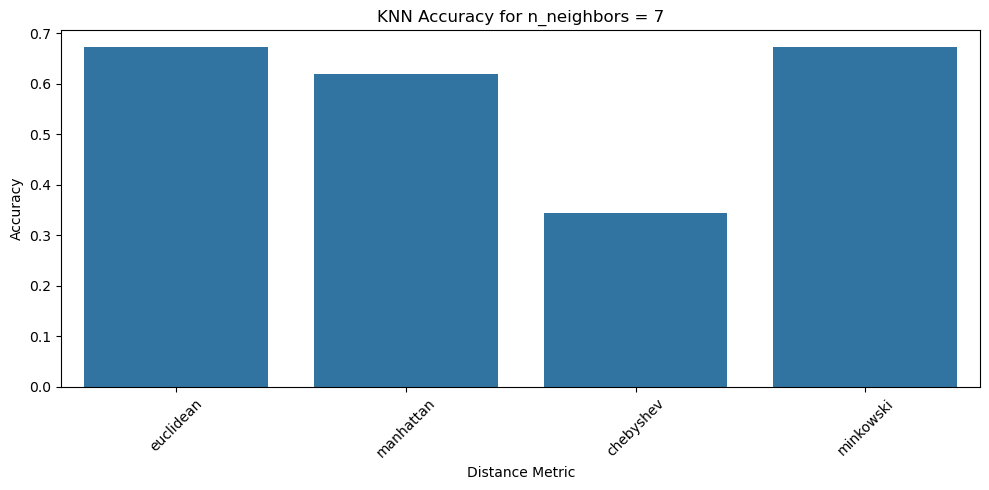

In [107]:
# Filter for n_neighbors = 3
df_7 = df[df['n_neighbors'] == 7]
print(df_7)
# Barplot for k=7
plt.figure(figsize=(10, 5))
sn.barplot(data=df_7, x='metric', y='accuracy', errorbar=None)
plt.title("KNN Accuracy for n_neighbors = 7")
plt.ylabel("Accuracy")
plt.xlabel("Distance Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now that we have confirmed the optimal sigma value sigma 11 or 0.00025, as it is the one that give the most consistent high result across all values we will create the database X with that value for future simplification

In [124]:

X_knn = {}
y_knn=[]


for person in people:
    for gesture in gestures:
        gesture_path = os.path.join(person, person, gesture)
        if os.path.exists(gesture_path):
            files = [f for f in os.listdir(gesture_path) if f.endswith('.csv')]
            dfs = []
            for f in files:
                df = pd.read_csv(os.path.join(gesture_path, f), dtype=np.float32)
                matrix, freqs = preprocess_spectrogram(df)
                pos_env, neg_env = extract_envelopes(matrix, freqs)
                features = build_feature_vector(pos_env, neg_env)
                dfs.append(features)
                y_knn.append(gesture)
            X_knn[f'{person}_{gesture}'] = dfs 



In [125]:

scaler= StandardScaler()
encoder=LabelEncoder()
#encode the gestures in y to be able to train the models
y_encoded_knn = encoder.fit_transform(y_knn)

flat_X_knn = [vec for sublist in X_knn.values() for vec in sublist]
max_len = max(len(f) for f in flat_X_knn)
X_padded_knn = np.array([np.pad(f, (0, max_len - len(f)), 'constant') for f in flat_X_knn])
scaler.fit(X_padded_knn)
X_scaled_knn=scaler.fit_transform(X_padded_knn)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_scaled_knn, y_encoded_knn, test_size=0.2, stratify=y_knn)


## Main characteristics of matrix

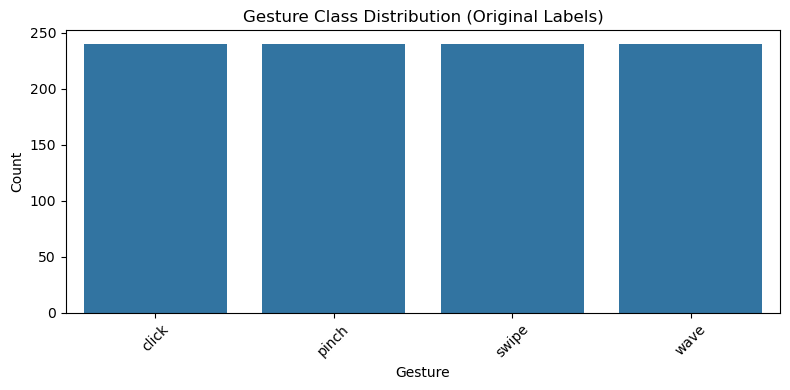

In [127]:
#Class distribution
plt.figure(figsize=(8, 4))
sn.countplot(x=y_knn)
plt.title("Gesture Class Distribution (Original Labels)")
plt.xlabel("Gesture")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

The classes are well distributed, suggesting an unbiased feature selection in terms of classes

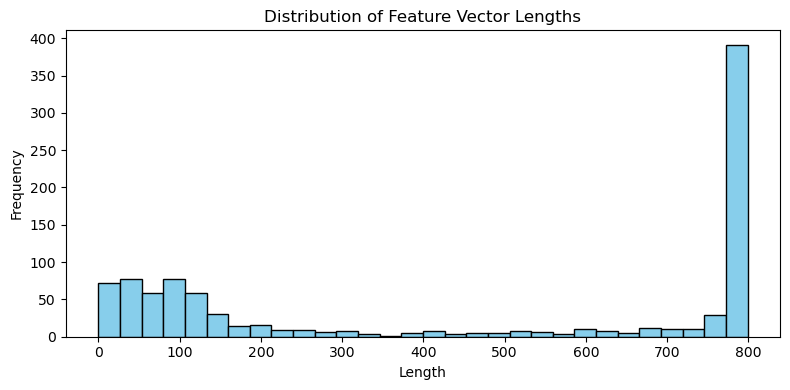

In [126]:
#feature lengths
lengths = [len(f) for f in flat_X_knn]
plt.figure(figsize=(8, 4))
plt.hist(lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Feature Vector Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()



Notes on distribution of feature vector lengths

In [112]:
#Correlation matrix
#df_features = pd.DataFrame(X_scaled_knn)
#df_features.columns = [f'feature_{i}' for i in range(df_features.shape[1])]

#corrMatrix = df_features.corr()


#Heatmap
#sn.heatmap(corrMatrix)
#plt.show()

As we can see, the features are very heavily correlated, hence a PCA operation could be used to enhance efficiency and reduce cost

# PCA

In [72]:
#padded features
def pad_to_max_length(feature_list, pad_value=0.0):
    max_len = max(len(vec) for vec in feature_list)
    padded = []
    for vec in feature_list:
        vec = np.pad(vec, (0, max_len - len(vec)), mode='constant', constant_values=pad_value)
        padded.append(vec)
    return np.array(padded)
    


In [84]:
#PCA for features

from sklearn.decomposition import PCA

X_gestures_knn={}

for k in gestures:
    data=[]
    for i in X_knn.keys():
        if k in i:
            data.extend(X_knn[i])
    X_gestures_knn[f'{k}']=data
    
            
X_all = np.vstack([np.array(X_gestures_knn[g]) for g in X_gestures_knn.keys()])

X_scaled = scaler.fit_transform(X_all)

# Create DataFrame for correlation matrix
df_features = pd.DataFrame(X_scaled, columns=[f'feature_{i}' for i in range(X_scaled.shape[1])])

# Compute and plot correlation matrix
corrMatrix = df_features.corr()

plt.figure(figsize=(10,8))
sn.heatmap(corrMatrix, cmap='coolwarm')
plt.title("Feature–Feature Correlation Matrix (Pre-PCA)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (240,) + inhomogeneous part.

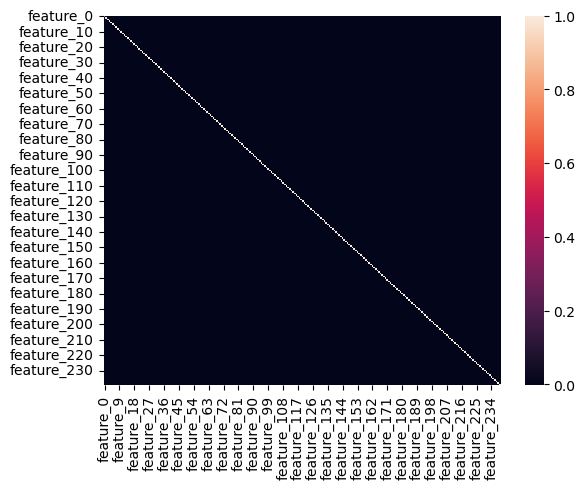

In [113]:
#Correlation matrix
pca = PCA()

flat_gesture_X = []
for k in X_gestures_knn.keys():
    flat_gesture_X.extend(X_PCA_knn_gesture[k])
X_gestures_scaled= scaler.fit_transform(flat_gesture_X)
df_features = pd.DataFrame(X_gestures_scaled)
df_features.columns = [f'feature_{i}' for i in range(df_features.shape[1])]

corrMatrix = df_features.corr()


#Heatmap
sn.heatmap(corrMatrix)
plt.show()


In [114]:
pca = PCA()

            
X_PCA_knn_gesture={}
for i in X_gestures_knn.keys():
        padded= pad_to_max_length(X_gestures_knn[i])
        X_PCA_knn_gesture[i]=pca.fit_transform(padded)


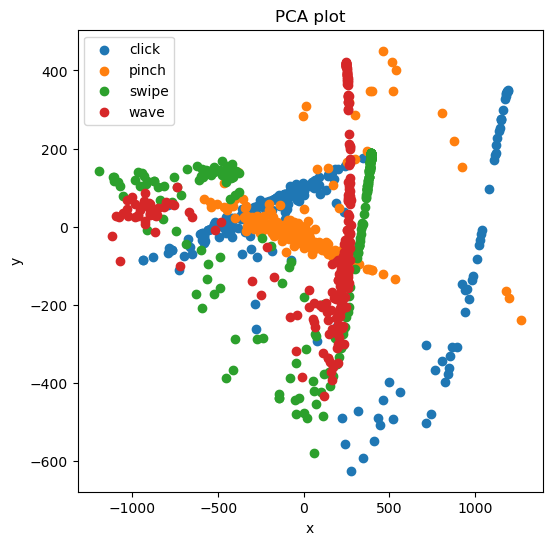

In [115]:

plt.figure(figsize=(6,6))
for label, data in X_PCA_knn_gesture.items():
    plt.scatter(data[:, 0], data[:, 1], label=label)
plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA plot')
plt.legend()
plt.show()

As we can see wave and swipe overlap a lot, and generally speaking the data clusters tightly which indicates consistent features.

Now to test for the accuracy:

In [116]:
y_encoded=encoder.fit_transform(y_knn)
flat_X = []
for k in X_PCA_knn_gesture.keys():
    flat_X.extend(X_PCA_knn_gesture[k])

X_scaled = scaler.fit_transform(flat_X)
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_scaled, y_encoded,test_size=0.2, stratify=y_encoded, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn.fit(X_train_PCA, y_train_PCA)
y_pred_PCA = knn.predict(X_test_PCA)

print('Accuracy score:', accuracy_score(y_test_PCA, y_pred_PCA))


Accuracy score: 0.28125


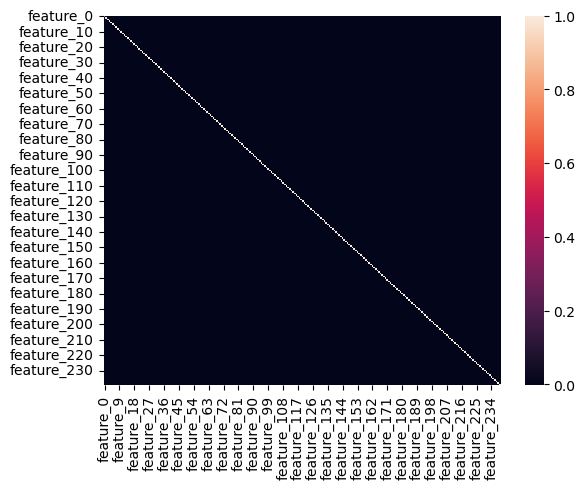

In [78]:
#Correlation matrix
df_features = pd.DataFrame(X_scaled)
df_features.columns = [f'feature_{i}' for i in range(df_features.shape[1])]

corrMatrix = df_features.corr()


#Heatmap
sn.heatmap(corrMatrix)
plt.show()

# Other models

We have to test the best sigma parameter for each model

In [119]:
#SVM
C_values=[0.01, 0.1, 1, 10, 100]
gamma_list=['scale', 'auto']
kernel_list=['linear', 'poly', 'rbf']
accuracy=[]
best_accuracies=[]
for name in X_names:
    accuracy_list=[]
    for kernel in kernel_list:
        for C in C_values:
            for gamma in gamma_list:
                    globals()[f'X_svm_sigma{name}'] = SVC(kernel = kernel, gamma = gamma, C=C)
                    globals()[f'X_svm_sigma{name}'].fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
                    globals()[f'y_pred_sigma{name}'] = (globals()[f'X_knn_sigma{name}']).predict(globals()[f'X_test_sigma{name}'])
                    acc = accuracy_score(globals()[f'y_test_sigma{name}'], globals()[f'y_pred_sigma{name}'])
                    accuracy_list.append((acc, C, gamma, kernel))
    accuracy.append(accuracy_list)
    best= max(accuracy_list, key=lambda x: x[0])
    best_accuracies.append(best[0])
    print(f" Sigma {name}: Best Accuracy = {best[0]:.4f} with C={best[1]}, gamma={best[2]}, kernel={best[3]}")
            


 Sigma 0: Best Accuracy = 0.5365 with C=0.01, gamma=scale, kernel=linear
 Sigma 1: Best Accuracy = 0.5938 with C=0.01, gamma=scale, kernel=linear
 Sigma 2: Best Accuracy = 0.5781 with C=0.01, gamma=scale, kernel=linear
 Sigma 3: Best Accuracy = 0.5833 with C=0.01, gamma=scale, kernel=linear
 Sigma 4: Best Accuracy = 0.5781 with C=0.01, gamma=scale, kernel=linear
 Sigma 5: Best Accuracy = 0.5000 with C=0.01, gamma=scale, kernel=linear
 Sigma 6: Best Accuracy = 0.5469 with C=0.01, gamma=scale, kernel=linear
 Sigma 7: Best Accuracy = 0.5573 with C=0.01, gamma=scale, kernel=linear
 Sigma 8: Best Accuracy = 0.5885 with C=0.01, gamma=scale, kernel=linear
 Sigma 9: Best Accuracy = 0.6094 with C=0.01, gamma=scale, kernel=linear
 Sigma 10: Best Accuracy = 0.6354 with C=0.01, gamma=scale, kernel=linear
 Sigma 11: Best Accuracy = 0.6510 with C=0.01, gamma=scale, kernel=linear
 Sigma 12: Best Accuracy = 0.6250 with C=0.01, gamma=scale, kernel=linear
 Sigma 13: Best Accuracy = 0.6198 with C=0.01, g

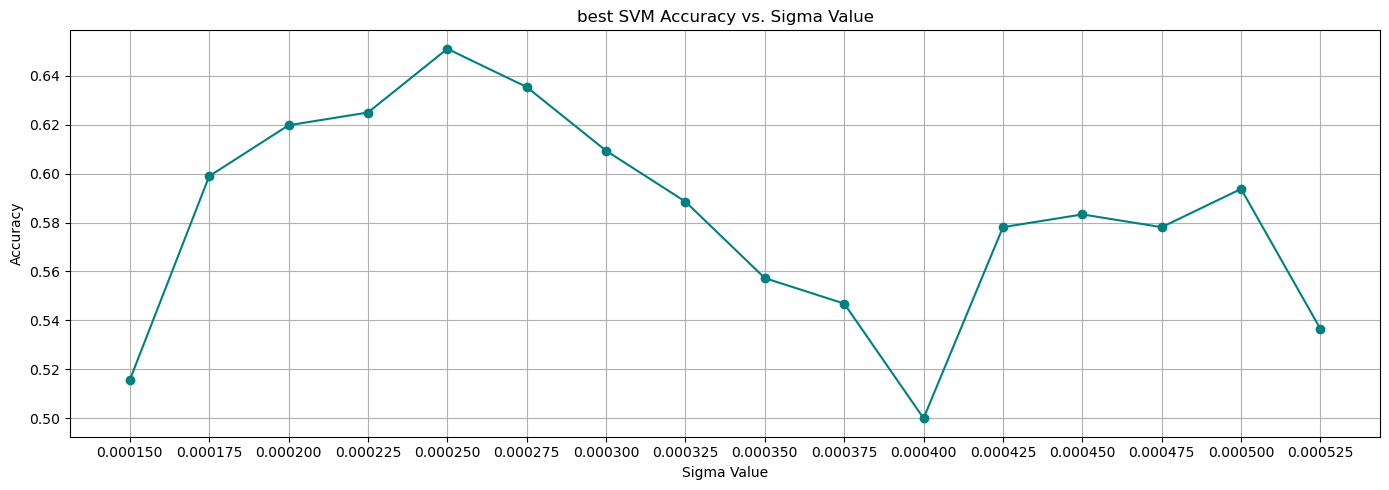

In [120]:

plt.figure(figsize=(14, 5))
plt.plot(sigma_list, best_accuracies, marker='o', linestyle='-', color='teal')
plt.title("best SVM Accuracy vs. Sigma Value")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()

In [121]:
#logistic Regression

C_values=[0.01, 0.1, 1, 10, 100]
accuracy=[]
best_accuracies=[]
for name in X_names:
    accuracy_list=[]
    for C in C_values:
            globals()[f'X_log_sigma{name}'] = SVC(max_iter=int(1e6), C=C)
            globals()[f'X_log_sigma{name}'].fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
            globals()[f'y_pred_sigma{name}'] = (globals()[f'X_knn_sigma{name}']).predict(globals()[f'X_test_sigma{name}'])
            acc = accuracy_score(globals()[f'y_test_sigma{name}'], globals()[f'y_pred_sigma{name}'])
            accuracy_list.append((acc, C))
    accuracy.append(accuracy_list)
    best= max(accuracy_list, key=lambda x: x[0])
    best_accuracies.append(best[0])
    print(f" Sigma {name}: Best Accuracy = {best[0]:.4f} with C={best[1]}")
            


 Sigma 0: Best Accuracy = 0.5365 with C=0.01
 Sigma 1: Best Accuracy = 0.5938 with C=0.01
 Sigma 2: Best Accuracy = 0.5781 with C=0.01
 Sigma 3: Best Accuracy = 0.5833 with C=0.01
 Sigma 4: Best Accuracy = 0.5781 with C=0.01
 Sigma 5: Best Accuracy = 0.5000 with C=0.01
 Sigma 6: Best Accuracy = 0.5469 with C=0.01
 Sigma 7: Best Accuracy = 0.5573 with C=0.01
 Sigma 8: Best Accuracy = 0.5885 with C=0.01
 Sigma 9: Best Accuracy = 0.6094 with C=0.01
 Sigma 10: Best Accuracy = 0.6354 with C=0.01
 Sigma 11: Best Accuracy = 0.6510 with C=0.01
 Sigma 12: Best Accuracy = 0.6250 with C=0.01
 Sigma 13: Best Accuracy = 0.6198 with C=0.01
 Sigma 14: Best Accuracy = 0.5990 with C=0.01
 Sigma 15: Best Accuracy = 0.5156 with C=0.01


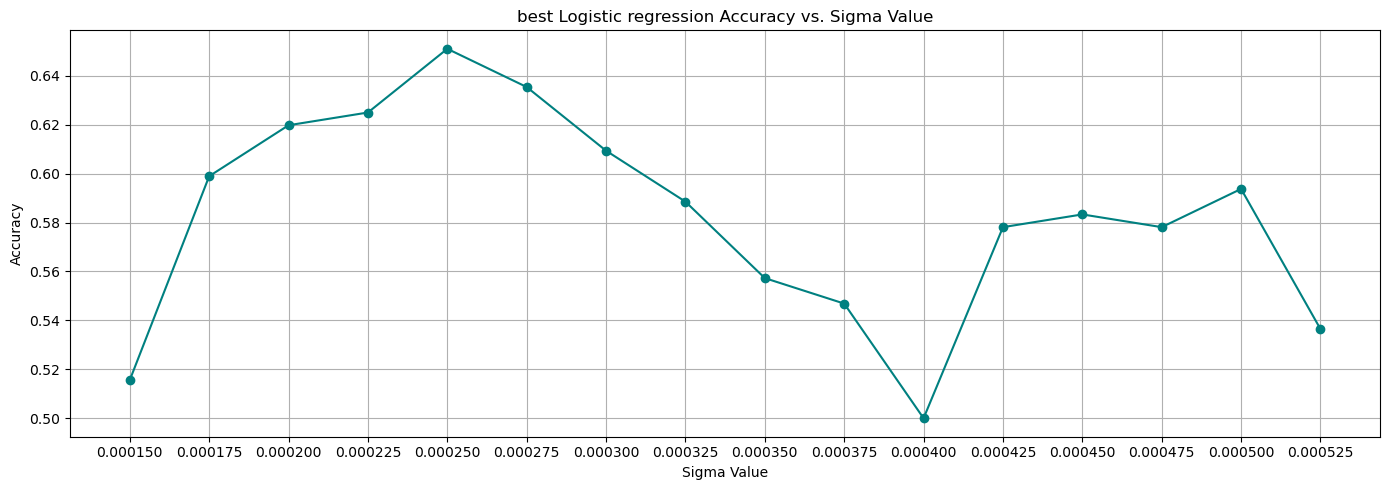

In [122]:

plt.figure(figsize=(14, 5))
plt.plot(sigma_list, best_accuracies, marker='o', linestyle='-', color='teal')
plt.title("best Logistic regression Accuracy vs. Sigma Value")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()